In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sympy as smp
from scipy.fft import fftfreq
from scipy.fft import fft, ifft
from datetime import datetime
import matplotlib.dates as mdates 
import scipy as scipy

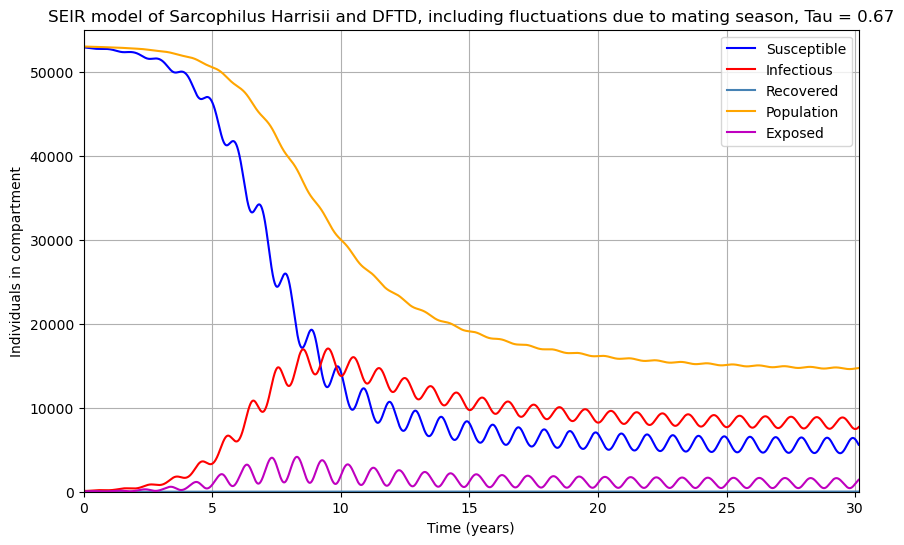

In [4]:
beta = 0.02  # Rate of infection from exposure (becoming infectious after being exposed) / day
gamma = 0.000001  # Rate of recovery / day
delta = 0.0021  # Morality rate / day
epsilon = 0.015  # Rate of exposure / day
omega = 0.0016  # Per capita population growth rate birthrate / day
roh = omega  # Per capita normal death rate (not including disease) / day

# Define the function fs to give a function of t that should spike in the mating season; 
# this is an additional coefficient to manage the periodic changes in behaviour and thus infection of Sarcophilus Hasirii

def fs(t):
    return ((2 * (-1671.74227799228 * np.sin(98 * np.pi / 365) / np.pi ** 2 - 1285.9555984556 * np.sin(154 * np.pi / 365) / np.pi ** 2 - 514.382239382239 * np.sin(182 * np.pi / 365) / np.pi ** 2 - 514.382239382239 * np.sin(168 * np.pi / 365) / np.pi ** 2 - 257.19111969112 * np.sin(141 * np.pi / 365) / np.pi ** 2 - 257.19111969112 * np.sin(84 * np.pi / 365) / np.pi ** 2 - 128.59555984556 * np.sin(14 * np.pi / 73) / np.pi ** 2 - 1.70530256582424e-13 * np.cos(112 * np.pi / 365) / np.pi - 1.13686837721616e-13 * np.cos(28 * np.pi / 73) / np.pi - 1.4210854715202e-14 * np.cos(84 * np.pi / 365) / np.pi - 5.6843418860808e-14 * np.cos(168 * np.pi / 365) / np.pi - 1.4210854715202e-14 * np.cos(182 * np.pi / 365) / np.pi + 3.5527136788005e-15 * np.cos(14 * np.pi / 73) / np.pi + 2.8421709430404e-14 * np.cos(126 * np.pi / 365) / np.pi + 1.13686837721616e-13 * np.cos(154 * np.pi / 365) / np.pi + 1.84741111297626e-13 * np.cos(98 * np.pi / 365) / np.pi + 128.59555984556 * np.sin(31 * np.pi / 73) / np.pi ** 2 + 514.382239382239 * np.sin(112 * np.pi / 365) / np.pi ** 2 + 900.168918918919 * np.sin(126 * np.pi / 365) / np.pi ** 2 + 3086.29343629344 * np.sin(28 * np.pi / 73) / np.pi ** 2) * np.sin(2 * np.pi * t / 365) / 365 + 2 * (-1671.74227799228 * np.cos(98 * np.pi / 365) / np.pi ** 2 - 1285.9555984556 * np.cos(154 * np.pi / 365) / np.pi ** 2 - 257.19111969112 * np.cos(84 * np.pi / 365) / np.pi ** 2 - 128.59555984556 * np.cos(14 * np.pi / 73) / np.pi ** 2 - 514.382239382239 * np.cos(168 * np.pi / 365) / np.pi ** 2 - 128.59555984556 * np.cos(31 * np.pi / 73) / np.pi ** 2 - 514.382239382239 * np.cos(182 * np.pi / 365) / np.pi ** 2 - 1.84741111297626e-13 * np.sin(98 * np.pi / 365) / np.pi - 1.13686837721616e-13 * np.sin(154 * np.pi / 365) / np.pi - 2.8421709430404e-14 * np.sin(126 * np.pi / 365) / np.pi - 3.5527136788005e-15 * np.sin(14 * np.pi / 73) / np.pi + 1.4210854715202e-14 * np.sin(84 * np.pi / 365) / np.pi + 1.4210854715202e-14 * np.sin(182 * np.pi / 365) / np.pi + 5.6843418860808e-14 * np.sin(168 * np.pi / 365) / np.pi + 1.13686837721616e-13 * np.sin(28 * np.pi / 73) / np.pi + 1.70530256582424e-13 * np.sin(112 * np.pi / 365) / np.pi + 257.19111969112 * np.cos(141 * np.pi / 365) / np.pi ** 2 + 514.382239382239 * np.cos(112 * np.pi / 365) / np.pi ** 2 + 900.168918918919 * np.cos(126 * np.pi / 365) / np.pi ** 2 + 3086.29343629344 * np.cos(28 * np.pi / 73) / np.pi ** 2) * np.cos(2 * np.pi * t / 365) / 365) + 0.167382450944095)/0.35

tau = 0.0 # Proportion of the population that is treated
K = 1000000
P0 = 1000000  # Initial population
E0 = 0  # initially exposed but not infectious
I0 = 100*1000000/53000 # initially infectious
R0 = 0  # initially recovered
D0 = 0  # initially dead
S0 = P0 - I0 - E0 - R0 - D0  # initially susceptible
days = 11000
t = np.linspace(0, days, days)

def protomodel(y, t, beta, gamma, delta, epsilon, omega, roh, tau, K):
    P, S, E, I, R, D = y
    dPdt = omega * P - roh * (P/K) * P - delta * I #Define the flows between compartments
    dSdt = omega * P - epsilon * fs(t) * (1-tau) * I * S / P - roh * (P/K) * S
    dEdt = epsilon * fs(t) * I * (1-tau) * S / P - (1 - 0.5*tau) * beta * E - roh * (P/K) * E
    dIdt = (1-0.5*tau) * beta * E - delta * I - gamma * I - roh * (P/K) * I
    dRdt = gamma * I - roh * R * (P/K)
    dDdt = delta * I + roh * (P/K) * P
    return [dPdt, dSdt, dEdt, dIdt, dRdt, dDdt]

y0 = [P0, S0, E0, I0, R0, D0]
protosolution = odeint(protomodel, y0, t, args=(beta, gamma, delta, epsilon, omega, roh, tau, K))

P, S, E, I, R, D = protosolution.T
#transpose the computed solution ot the differential equations as a matrix
#plot the output
plt.figure(figsize=(10, 6))
plt.plot(t/365, S*53000/1000000, 'b', label='Susceptible')
plt.plot(t/365, I*53000/1000000, 'r', label='Infectious')
plt.plot(t/365, R*53000/1000000, 'steelblue', label='Recovered')
plt.plot(t/365, P*53000/1000000, 'orange', label='Population')
plt.plot(t/365, E*53000/1000000, 'm', label='Exposed')
ax = plt.gca()
ax.set_xlim([0,days/365])
ax.set_ylim([0, 55000])
#lt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('SEIR model of Sarcophilus Harrisii and DFTD, including fluctuations due to mating season, Tau = 0.67')
plt.xlabel('Time (years)')
plt.ylabel('Individuals in compartment')
plt.legend()
plt.grid(True)
plt.show()



/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


            30             29             28             27
-1.152e-72 x  + 2.624e-69 x  - 1.802e-66 x  - 2.925e-65 x 
              26             25            24             23
 + 3.626e-61 x  + 5.569e-59 x  - 6.94e-56 x  - 3.178e-53 x 
              22             21             20             19
 + 6.989e-51 x  + 9.945e-48 x  + 1.393e-45 x  - 2.095e-42 x 
              18             17             16             15
 - 9.414e-40 x  + 3.306e-37 x  + 3.089e-34 x  - 5.059e-32 x 
              14             13             12             11
 - 1.078e-28 x  + 5.941e-26 x  - 1.138e-23 x  + 7.159e-24 x 
              10             9             8             7
 + 3.176e-19 x  - 3.383e-17 x - 2.413e-15 x + 5.307e-13 x
              6             5             4             3             2
 + 2.501e-12 x - 3.453e-09 x + 1.937e-08 x + 1.008e-05 x + 4.537e-05 x - 0.006455 x + 0.06862


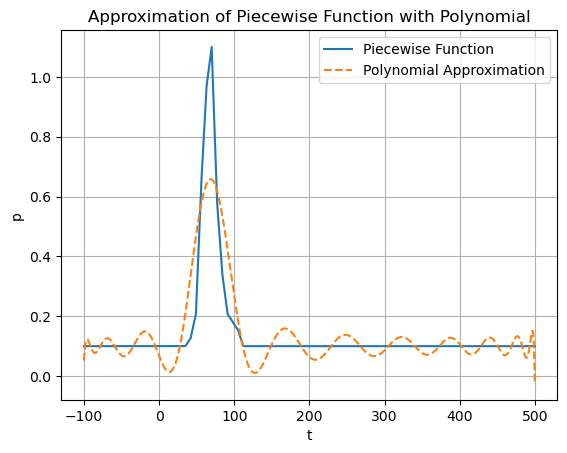

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the piecewise function
def piecewisee(t):
    nr = 0.1  # Assuming nr is defined somewhere
    if t < 35:
        return nr
    elif 35 <= t < 42:
        return (t/7 - 5)/37 + nr
    elif 42 <= t < 49:
        return (3*t/7 - 17)/37 + nr
    elif 49 <= t < 56:
        return (16*t/7 - 108)/37 + nr
    elif 56 <= t < 63:
        return (12*t/7 - 76)/37 + nr
    elif 63 <= t < 70:
        return (5*t/7 - 13)/37 + nr
    elif 70 <= t < 77:
        return (-19*t/7 + 227)/37 + nr
    elif 77 <= t < 84:
        return (-9*t/7 + 117)/37 + nr
    elif 84 <= t < 91:
        return (-5*t/7 + 69)/37 + nr
    elif 91 <= t < 98:
        return (-t/7 + 17)/37 + nr
    elif 98 <= t < 105:
        return (-t/7 + 17)/37 + nr
    elif 105 <= t < 112:
        return (-2*t/7 + 32)/37 + nr
    else:
        return nr

# Generate data points
x = np.linspace(-100, 500, 10000)
y = [piecewisee(t_val) for t_val in x]

# Fit a polynomial curve
degree = 30  # Choose the degree of the polynomial
coefficients = np.polyfit(x, y, degree)
poly = np.poly1d(coefficients)
print(poly)
def function(t):
    return poly(t)
# Generate y values for the polynomial curve
y_poly = poly(x)

# Plot the results
plt.plot(x, y, label='Piecewise Function')
plt.plot(x, y_poly, label='Polynomial Approximation', linestyle='--')
plt.xlabel('t')
plt.ylabel('p')
plt.title('Approximation of Piecewise Function with Polynomial')
plt.legend()
plt.grid(True)
plt.show()

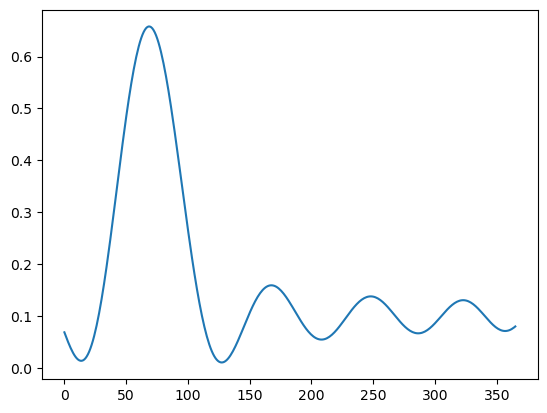

In [11]:
def function(t):
    return poly(t)
x = np.linspace(0,365,365)
plt.plot(x, function(x))

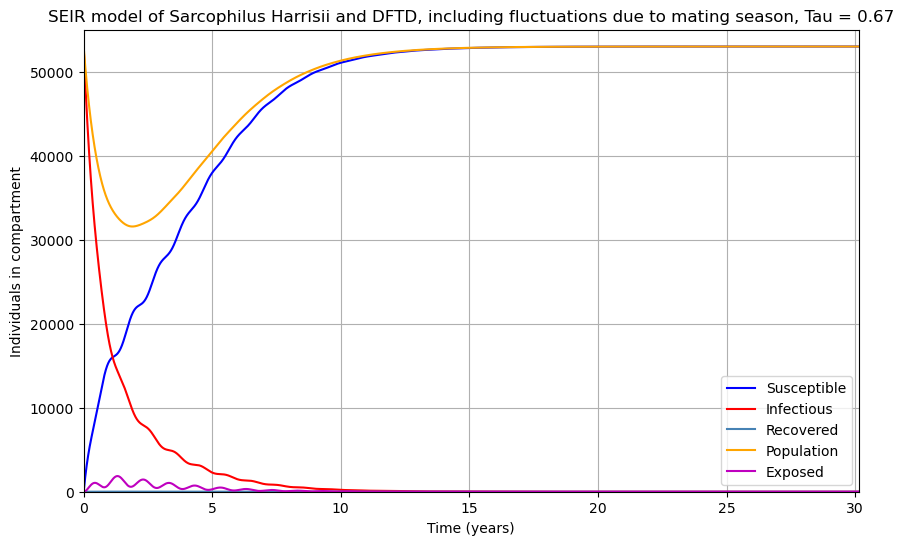

In [7]:
beta = 0.02  # Rate of infection from exposure (becoming infectious after being exposed) / day
gamma = 0.000001  # Rate of recovery / day
delta = 0.0021  # Morality rate / day
epsilon = 0.015  # Rate of exposure / day
omega = 0.0016  # Per capita population growth rate birthrate / day
roh = omega  # Per capita normal death rate (not including disease) / day

# Define the function fs to give a function of t that should spike in the mating season; 
# this is an additional coefficient to manage the periodic changes in behaviour and thus infection of Sarcophilus Hasirii

def fs(t):
    return ((2 * (-1671.74227799228 * np.sin(98 * np.pi / 365) / np.pi ** 2 - 1285.9555984556 * np.sin(154 * np.pi / 365) / np.pi ** 2 - 514.382239382239 * np.sin(182 * np.pi / 365) / np.pi ** 2 - 514.382239382239 * np.sin(168 * np.pi / 365) / np.pi ** 2 - 257.19111969112 * np.sin(141 * np.pi / 365) / np.pi ** 2 - 257.19111969112 * np.sin(84 * np.pi / 365) / np.pi ** 2 - 128.59555984556 * np.sin(14 * np.pi / 73) / np.pi ** 2 - 1.70530256582424e-13 * np.cos(112 * np.pi / 365) / np.pi - 1.13686837721616e-13 * np.cos(28 * np.pi / 73) / np.pi - 1.4210854715202e-14 * np.cos(84 * np.pi / 365) / np.pi - 5.6843418860808e-14 * np.cos(168 * np.pi / 365) / np.pi - 1.4210854715202e-14 * np.cos(182 * np.pi / 365) / np.pi + 3.5527136788005e-15 * np.cos(14 * np.pi / 73) / np.pi + 2.8421709430404e-14 * np.cos(126 * np.pi / 365) / np.pi + 1.13686837721616e-13 * np.cos(154 * np.pi / 365) / np.pi + 1.84741111297626e-13 * np.cos(98 * np.pi / 365) / np.pi + 128.59555984556 * np.sin(31 * np.pi / 73) / np.pi ** 2 + 514.382239382239 * np.sin(112 * np.pi / 365) / np.pi ** 2 + 900.168918918919 * np.sin(126 * np.pi / 365) / np.pi ** 2 + 3086.29343629344 * np.sin(28 * np.pi / 73) / np.pi ** 2) * np.sin(2 * np.pi * t / 365) / 365 + 2 * (-1671.74227799228 * np.cos(98 * np.pi / 365) / np.pi ** 2 - 1285.9555984556 * np.cos(154 * np.pi / 365) / np.pi ** 2 - 257.19111969112 * np.cos(84 * np.pi / 365) / np.pi ** 2 - 128.59555984556 * np.cos(14 * np.pi / 73) / np.pi ** 2 - 514.382239382239 * np.cos(168 * np.pi / 365) / np.pi ** 2 - 128.59555984556 * np.cos(31 * np.pi / 73) / np.pi ** 2 - 514.382239382239 * np.cos(182 * np.pi / 365) / np.pi ** 2 - 1.84741111297626e-13 * np.sin(98 * np.pi / 365) / np.pi - 1.13686837721616e-13 * np.sin(154 * np.pi / 365) / np.pi - 2.8421709430404e-14 * np.sin(126 * np.pi / 365) / np.pi - 3.5527136788005e-15 * np.sin(14 * np.pi / 73) / np.pi + 1.4210854715202e-14 * np.sin(84 * np.pi / 365) / np.pi + 1.4210854715202e-14 * np.sin(182 * np.pi / 365) / np.pi + 5.6843418860808e-14 * np.sin(168 * np.pi / 365) / np.pi + 1.13686837721616e-13 * np.sin(28 * np.pi / 73) / np.pi + 1.70530256582424e-13 * np.sin(112 * np.pi / 365) / np.pi + 257.19111969112 * np.cos(141 * np.pi / 365) / np.pi ** 2 + 514.382239382239 * np.cos(112 * np.pi / 365) / np.pi ** 2 + 900.168918918919 * np.cos(126 * np.pi / 365) / np.pi ** 2 + 3086.29343629344 * np.cos(28 * np.pi / 73) / np.pi ** 2) * np.cos(2 * np.pi * t / 365) / 365) + 0.167382450944095)/0.35

tau = 0.67 # Proportion of the population that is treated
K = 1000000
P0 = 1000000  # Initial population
E0 = 0  # initially exposed but not infectious
I0 = 1000000 # initially infectious
R0 = 0  # initially recovered
D0 = 0  # initially dead
S0 = P0 - I0 - E0 - R0 - D0  # initially susceptible
days = 11000
t = np.linspace(0, days, days)

def protomodel(y, t, beta, gamma, delta, epsilon, omega, roh, tau, K):
    P, S, E, I, R, D = y
    dPdt = omega * P - roh * (P/K) * P - delta * I #Define the flows between compartments
    dSdt = omega * P - epsilon * fs(t) * (1-tau) * I * S / P - roh * (P/K) * S
    dEdt = epsilon * fs(t) * I * (1-tau) * S / P - (1 - 0.5*tau) * beta * E - roh * (P/K) * E
    dIdt = (1-0.5*tau) * beta * E - delta * I - gamma * I - roh * (P/K) * I
    dRdt = gamma * I - roh * R * (P/K)
    dDdt = delta * I + roh * (P/K) * P
    return [dPdt, dSdt, dEdt, dIdt, dRdt, dDdt]

y0 = [P0, S0, E0, I0, R0, D0]
protosolution = odeint(protomodel, y0, t, args=(beta, gamma, delta, epsilon, omega, roh, tau, K))

P, S, E, I, R, D = protosolution.T
#transpose the computed solution ot the differential equations as a matrix
#plot the output
plt.figure(figsize=(10, 6))
plt.plot(t/365, S*53000/1000000, 'b', label='Susceptible')
plt.plot(t/365, I*53000/1000000, 'r', label='Infectious')
plt.plot(t/365, R*53000/1000000, 'steelblue', label='Recovered')
plt.plot(t/365, P*53000/1000000, 'orange', label='Population')
plt.plot(t/365, E*53000/1000000, 'm', label='Exposed')
ax = plt.gca()
ax.set_xlim([0,days/365])
ax.set_ylim([0, 55000])
#lt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('SEIR model of Sarcophilus Harrisii and DFTD, including fluctuations due to mating season, Tau = 0.67')
plt.xlabel('Time (years)')
plt.ylabel('Individuals in compartment')
plt.legend()
plt.grid(True)
plt.show()



In [4]:
from sympy import Piecewise, symbols

def piecewisee(t):
    nr = 0.1  # Assuming nr is defined somewhere
   
    return Piecewise(
        (nr, t_symbol < 35),
        ((t_symbol/7 - 5)/37 + nr, (35 <= t_symbol) & (t_symbol < 42)),
        ((3*t_symbol/7 - 17)/37 + nr, (42 <= t_symbol) & (t_symbol < 49)),
        ((16*t_symbol/7 - 108)/37 + nr, (49 <= t_symbol) & (t_symbol < 56)),
        ((12*t_symbol/7 - 76)/37 + nr, (56 <= t_symbol) & (t_symbol < 63)),
        ((5*t_symbol/7 - 13)/37 + nr, (63 <= t_symbol) & (t_symbol < 70)),
        ((-19*t_symbol/7 + 227)/37 + nr, (70 <= t_symbol) & (t_symbol < 77)),
        ((-9*t_symbol/7 + 117)/37 + nr, (77 <= t_symbol) & (t_symbol < 84)),
        ((-5*t_symbol/7 + 69)/37 + nr, (84 <= t_symbol) & (t_symbol < 91)),
        ((-t_symbol/7 + 17)/37 + nr, (91 <= t_symbol) & (t_symbol < 98)),
        ((-t_symbol/7 + 17)/37 + nr, (98 <= t_symbol) & (t_symbol < 105)),
        ((-2*t_symbol/7 + 32)/37 + nr, (105 <= t_symbol) & (t_symbol < 112)),
        (nr, True)
    )
nr = 0.1
t_symbol = symbols('t_symbol')
p =smp.Piecewise((nr, t_symbol < 35),
        ((t_symbol/7 - 5)/37 + nr, (35 <= t_symbol) & (t_symbol < 42)),
        ((3*t_symbol/7 - 17)/37 + nr, (42 <= t_symbol) & (t_symbol < 49)),
        ((16*t_symbol/7 - 108)/37 + nr, (49 <= t_symbol) & (t_symbol < 56)),
        ((12*t_symbol/7 - 76)/37 + nr, (56 <= t_symbol) & (t_symbol < 63)),
        ((5*t_symbol/7 - 13)/37 + nr, (63 <= t_symbol) & (t_symbol < 70)),
        ((-19*t_symbol/7 + 227)/37 + nr, (70 <= t_symbol) & (t_symbol < 77)),
        ((-9*t_symbol/7 + 117)/37 + nr, (77 <= t_symbol) & (t_symbol < 84)),
        ((-5*t_symbol/7 + 69)/37 + nr, (84 <= t_symbol) & (t_symbol < 91)),
        ((-t_symbol/7 + 17)/37 + nr, (91 <= t_symbol) & (t_symbol < 98)),
        ((-t_symbol/7 + 17)/37 + nr, (98 <= t_symbol) & (t_symbol < 105)),
        ((-2*t_symbol/7 + 32)/37 + nr, (105 <= t_symbol) & (t_symbol < 112)),
        (nr, t_symbol>=112))
# Example usage
fs = smp.fourier_series(p, (t_symbol,0,365))
fs.truncate(4).simplify

<bound method Basic.simplify of 2*(-1671.74227799228*sin(98*pi/365)/pi**2 - 1285.9555984556*sin(154*pi/365)/pi**2 - 514.382239382239*sin(182*pi/365)/pi**2 - 514.382239382239*sin(168*pi/365)/pi**2 - 257.19111969112*sin(141*pi/365)/pi**2 - 257.19111969112*sin(84*pi/365)/pi**2 - 128.59555984556*sin(14*pi/73)/pi**2 - 1.70530256582424e-13*cos(112*pi/365)/pi - 1.13686837721616e-13*cos(28*pi/73)/pi - 1.4210854715202e-14*cos(84*pi/365)/pi - 5.6843418860808e-14*cos(168*pi/365)/pi - 1.4210854715202e-14*cos(182*pi/365)/pi + 3.5527136788005e-15*cos(14*pi/73)/pi + 2.8421709430404e-14*cos(126*pi/365)/pi + 1.13686837721616e-13*cos(154*pi/365)/pi + 1.84741111297626e-13*cos(98*pi/365)/pi + 128.59555984556*sin(31*pi/73)/pi**2 + 514.382239382239*sin(112*pi/365)/pi**2 + 900.168918918919*sin(126*pi/365)/pi**2 + 3086.29343629344*sin(28*pi/73)/pi**2)*sin(2*pi*t_symbol/365)/365 + 2*(-417.93556949807*sin(169*pi/365)/pi**2 - 321.4888996139*sin(57*pi/365)/pi**2 - 64.2977799227799*sin(168*pi/365)/pi**2 - 128.5955

In [17]:
tS = P[:3650]
St = P[7350:]
scipy.stats.ttest_ind(tS, St)

TtestResult(statistic=270.65799832978786, pvalue=0.0, df=7298.0)